# Сборный проект

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt
from math import factorial
import plotly
import plotly.express as px
import seaborn as sns

In [2]:
games = pd.read_csv('/datasets/games.csv')

### Изучение общей информации

In [3]:
games.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


***В датасете много пропусков в столбцах с рейтингами:Critic_Score,User_Score,Rating.Названия столбцов в разных регистрах***

### Подготовка данных

In [5]:
#приведу названия столбцов к общему регистру
games.columns = map(str.lower, games.columns)
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [6]:
#проверяю количество 'NaN' значений
games.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [7]:
games['user_score'].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
1.5       2
0.9       2
0.7       2
9.7       1
0         1
Name: user_score, Length: 96, dtype: int64

***В столбце user_score есть значения TBD - To Be Decided -это значит что рейтинг еще не определен,заменю эти значения нолями***  

In [8]:
games['critic_score'].value_counts()

70.0    256
71.0    254
75.0    245
78.0    240
73.0    238
       ... 
20.0      3
17.0      1
22.0      1
13.0      1
21.0      1
Name: critic_score, Length: 82, dtype: int64

In [9]:
games['rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

In [10]:
#убираю значения 'NaN'
games['year_of_release'] = games['year_of_release'].fillna(0)
games['year_of_release'] = games['year_of_release'].astype(int)
games['user_score'] = pd.to_numeric(games['user_score'], errors='coerce') #убираю 'TBD' значения
games['user_score'] = games['user_score'].fillna(0)
games['critic_score'] = games['critic_score'].fillna(0)
games['genre'] = games['genre'].fillna(0)
games['rating'] = games['rating'].fillna(0)
#напишу функцию которая принимает значения 0 и меняет их на значения Unknown
def critics(row):
    if row == 0:
        return 'Unknown'
    if row != 0:
        return row

games['rating'] = games['rating'].apply(critics)
#добавлю столбец с сумой общих продаж
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 12 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16715 non-null int64
genre              16715 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       16715 non-null float64
user_score         16715 non-null float64
rating             16715 non-null object
total_sales        16715 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.5+ MB


***Заменил пропущенные значения в столбиках с рейтингами значением Unknown,так как оценки в рейтингах абсолютно субьективны и их невозможно как то спрогнозировать.year_of_release задал тип int.***

### Исследовательский анализ данных

In [11]:
#собираюсь посмотреть количество выпущенных игр по годам
curiosity = games.pivot_table(
    index='year_of_release',values='name',aggfunc='count')
curiosity

,name
year_of_release,
0,269
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16


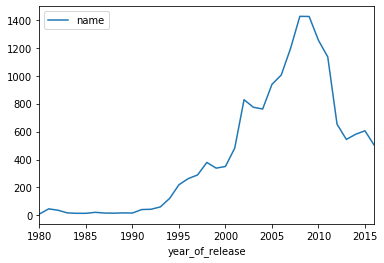

In [12]:
#выведу эти же значения графиком
curiosity = games.query('year_of_release != 0').pivot_table(
    index='year_of_release',values='name',aggfunc='count').plot()

***Мы можем наблюдать на графике и в таблице как с начала 80-х годов производство игр только нарастало,но в середине 2000-х производство замедлилось.Думаю это связано с тем что игры стали намного сложнее и их производство занимает намного больше времени.Я напрмер жду Half-Life 3 уже 17 лет.Я так понимаю что мне не нужны данные за все время,скорее всего только последние 5 лет***

In [14]:
patform_legacy_2 = games.query('year_of_release > 0 and year_of_release < 2016').pivot_table(
    index='platform',values='year_of_release',aggfunc=['min','max'])
patform_legacy_2['difference'] = patform_legacy_2['max'] - patform_legacy_2['min']
patform_legacy_2['difference'].mean()

7.32258064516129

***Судя по графику  и рассчетам платформы 'живут' в среднем 7 лет***

In [15]:
patform_legacy_2

,min,max,difference
,year_of_release,year_of_release,
platform,,,
2600,1980,1989,9
3DO,1994,1995,1
3DS,2011,2015,4
DC,1998,2008,10
DS,1985,2013,28
GB,1988,2001,13
GBA,2000,2007,7
GC,2001,2007,6


***Удивительно ,но плафторма DS от Nintendo продавалась 28! лет,а вот платформа TG16 порсуществовала меньше года,видимо уребят что-то пошло нет так***

In [16]:
#собираюсь посмотреть рейтинг топ платформы по сумарным продажам начиная от 2012 года
rating_top_platforms = games.query('year_of_release >= 2010').pivot_table(
    index='platform',values=['na_sales','eu_sales','jp_sales','other_sales','total_sales'],aggfunc='sum').sort_values(
    by='total_sales',ascending=False)
rating_top_platforms.head(10)

,eu_sales,jp_sales,na_sales,other_sales,total_sales
platform,,,,,
PS3,213.60,59.26,229.25,85.63,587.74
X360,163.41,5.46,334.18,47.36,550.41
PS4,141.09,15.96,108.74,48.35,314.14
3DS,61.27,100.62,82.65,13.27,257.81
Wii,65.91,17.75,121.20,18.11,222.97
XOne,51.59,0.34,93.12,14.27,159.32
DS,28.06,27.90,59.66,8.13,123.75
PC,68.82,0.00,39.07,14.07,121.96
WiiU,25.13,13.01,38.10,5.95,82.19


<a class="anchor" id="21-bullet">

***Можем наблюдать как доминирует Playstation 3.Главный конкурент XBOX на втором месте***

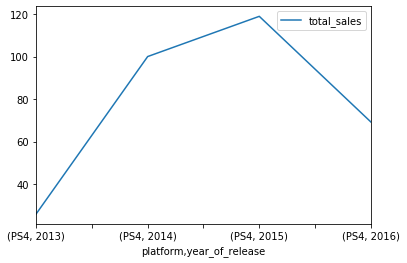

In [17]:
#хочу посмотреть распределение платформ по продажам в графиках для определения их актуальности
PS4 = games.query('year_of_release >= 2010 and platform == "PS4"').pivot_table(
    index=['platform','year_of_release'],values='total_sales',aggfunc='sum').plot()

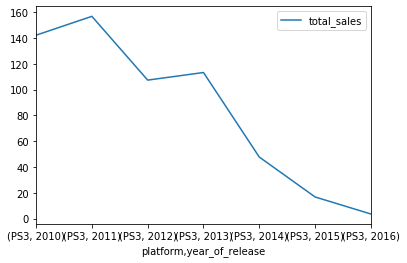

In [18]:
PS3 = games.query('year_of_release >= 2010 and platform == "PS3"').pivot_table(
    index=['platform','year_of_release'],values='total_sales',aggfunc='sum').plot()

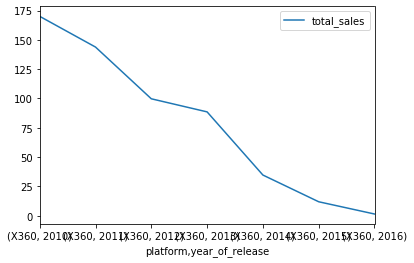

In [19]:
X360 = games.query('year_of_release >= 2010 and platform == "X360"').pivot_table(
    index=['platform','year_of_release'],values='total_sales',aggfunc='sum').plot()

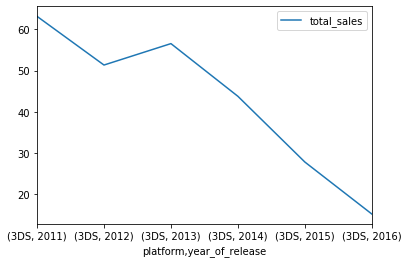

In [20]:
DS_3 = games.query('year_of_release >= 2010 and platform == "3DS"').pivot_table(
    index=['platform','year_of_release'],values='total_sales',aggfunc='sum').plot()

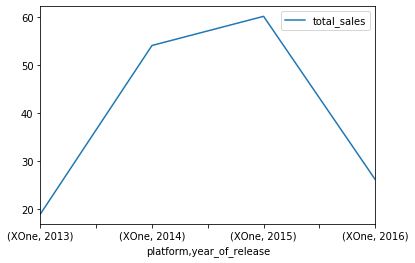

In [21]:
XOne = games.query('year_of_release >= 2010 and platform == "XOne"').pivot_table(
    index=['platform','year_of_release'],values='total_sales',aggfunc='sum').plot()

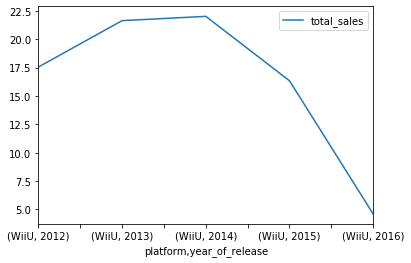

In [22]:
WiiU = games.query('year_of_release >= 2010 and platform == "WiiU"').pivot_table(
    index=['platform','year_of_release'],values='total_sales',aggfunc='sum').plot()

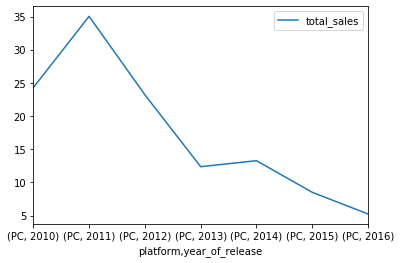

In [23]:
PC = games.query('year_of_release >= 2010 and platform == "PC"').pivot_table(
    index=['platform','year_of_release'],values='total_sales',aggfunc='sum').plot()

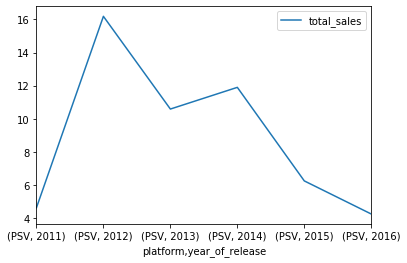

In [24]:
PSV = games.query('year_of_release >= 2010 and platform == "PSV"').pivot_table(
    index=['platform','year_of_release'],values='total_sales',aggfunc='sum').plot()

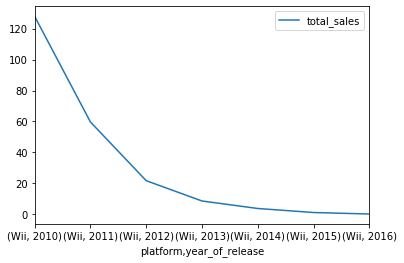

In [25]:
Wii = games.query('year_of_release >= 2010 and platform == "Wii"').pivot_table(
    index=['platform','year_of_release'],values='total_sales',aggfunc='sum').plot()

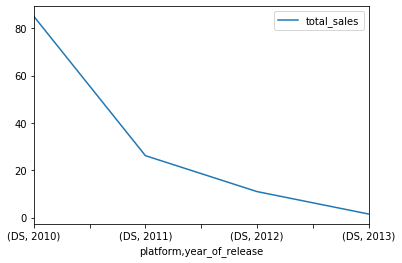

In [26]:
DS = games.query('year_of_release >= 2010 and platform == "DS"').pivot_table(
    index=['platform','year_of_release'],values='total_sales',aggfunc='sum').plot()

***Из топ 10 консолей не все актуальны на 2016 год как показывают графики выше.Предлагаю оставить топ 5 платформ,а именно PS4,XoNE,WiiU,PC,PSV.Данные консоли я выбрал по продажам из гафиков выше а так же еще раз просмотрел график на котором указана 'жизнь' всех консолей и отобрал самые актуальные платформы.PC я оставил в списке потому что это всегда актуальная платформа***

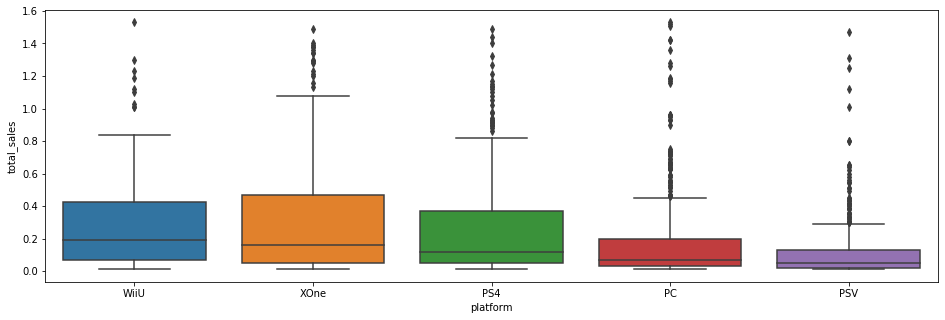

In [27]:
#собираюсь построить 'ящики с усами' по глобальным продажам игр в разбивке по топ платформам
top_5_platforms = ['PS4','PC','XOne','WiiU','PSV']
sea = games.query('year_of_release >= 2010 and platform in @top_5_platforms and total_sales < 1.53 ')
sea2 = sea[['platform','total_sales']]
median = sea2.groupby(by=["platform"])["total_sales"].median().sort_values(ascending=False).index
fig, ax = plt.subplots(1,1,figsize=(16, 5))
sns.boxplot(x=sea2["platform"], y=sea2['total_sales'],ax=ax,order=median);

***На данном графике хорошо видны все платформы и мы можем иметь примерное представление о медианных продажах игр для каждой платформы.Исходя из графика лучше всего игры продаются для платформы  от Nintendo.Очень хорошие  показатели у консоли XOne которая превзошла главного конкурента в лице SONY которая замыкает тройку***

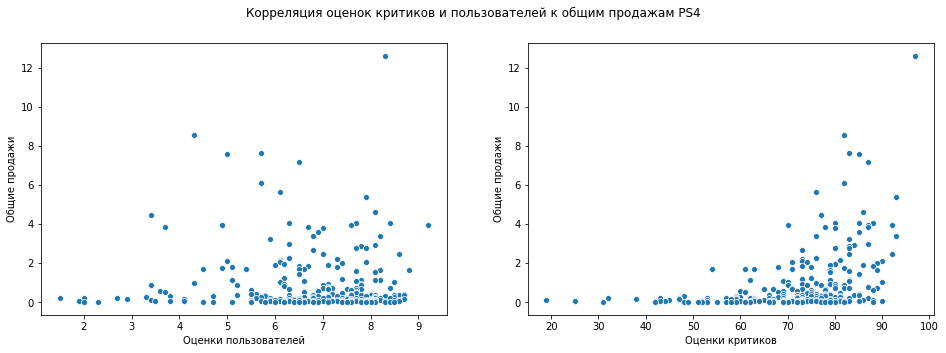

In [28]:
#собираюсь построить диаграмму рассеяния для PS4 так как на мой взгляд это самая перспективная консоль
#и посмотреть корреляцию между оценками критиков и пользователей к продажам
critics = games.query('platform == "PS4" and year_of_release >= 2010 and platform in @top_5_platforms')
critics = critics.query(
    'critic_score != 0 and user_score != 0')
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.scatterplot(x='user_score',y="total_sales",data=critics,ax=axes[0]);
sns.scatterplot(x='critic_score',y="total_sales",data=critics,ax=axes[1]);

axes[0].set_xlabel('Оценки пользователей')
axes[0].set_ylabel('Общие продажи')
axes[1].set_xlabel('Оценки критиков')
axes[1].set_ylabel('Общие продажи')
fig.suptitle('Корреляция оценок критиков и пользователей к общим продажам PS4');

In [29]:
#теперь посчитаю корреляцию вручную
print(
    'Корреляция оценок критиков к общим продажам:',critics['total_sales'].corr(critics['user_score']))
print(
     'Корреляция оценок пользователей к общим продажам:',critics['total_sales'].corr(critics['critic_score']))

Корреляция оценок критиков к общим продажам: -0.03362497596528878
Корреляция оценок пользователей к общим продажам: 0.40589480145836687


***Как мы видим и из графиков и из рассчетов связи между оценками критиков и пользователей с общими продажами очень слабые,поэтому данные оценки не влияют на продажи игр на PS4***

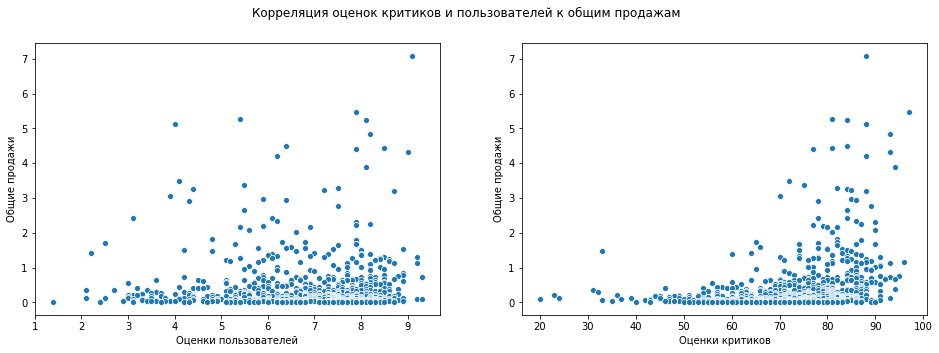

In [30]:
critics_2 = games.query('platform != "PS4" and year_of_release >= 2010 and platform in @top_5_platforms')
critics_2 = critics_2.query(
    'critic_score != 0 and user_score != 0')
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.scatterplot(x='user_score',y="total_sales",data=critics_2,ax=axes[0]);
sns.scatterplot(x='critic_score',y="total_sales",data=critics_2,ax=axes[1]);
axes[0].set_xlabel('Оценки пользователей')
axes[0].set_ylabel('Общие продажи')
axes[1].set_xlabel('Оценки критиков')
axes[1].set_ylabel('Общие продажи')
fig.suptitle('Корреляция оценок критиков и пользователей к общим продажам');

In [31]:
#теперь посчитаю корреляцию вручную
print(
    'Корреляция оценок критиков к общим продажам:',critics_2['total_sales'].corr(critics_2['user_score']))
print(
     'Корреляция оценок пользователей к общим продажам:',critics_2['total_sales'].corr(critics_2['critic_score']))

Корреляция оценок критиков к общим продажам: 0.026933413231208358
Корреляция оценок пользователей к общим продажам: 0.3143745936367898


<a class="anchor" id="22-bullet">

***Тут мы тоже видим что оценки критиков не влияют на продажи игр для остальных платформ***

In [32]:
#Хочу посмотреть на общее распределение игр по жанрам
genre = games.query('year_of_release >= 2010 and platform in @top_5_platforms').pivot_table(
    index='genre',values='name',aggfunc='count').sort_values(by='name',ascending=False)
genre

,name
genre,
Action,546
Role-Playing,210
Adventure,171
Shooter,168
Sports,144
Misc,96
Racing,86
Strategy,81
Simulation,70


***Игр в жанре Action выпускают больше всего***

In [33]:
genre_sales = games.query('year_of_release >= 2010 and platform in @top_5_platforms').pivot_table(
    index='genre',values='total_sales',aggfunc='sum').sort_values(by='total_sales',ascending=False)
genre_sales

,total_sales
genre,
Action,191.14
Shooter,183.74
Sports,96.86
Role-Playing,83.08
Racing,35.01
Misc,33.42
Platform,33.03
Fighting,20.12
Strategy,20.01


***Action игры продаются в сумме больше всех,но скорее всего это потому что их количество намного больше остальных*** 

In [34]:
genre_sales_mean = games.query('year_of_release >= 2010 and platform in @top_5_platforms').pivot_table(
    index='genre',values='total_sales',aggfunc='mean').sort_values(by='total_sales',ascending=False)
genre_sales_mean

,total_sales
genre,
Shooter,1.093690
Platform,0.674082
Sports,0.672639
Racing,0.407093
Fighting,0.402400
Role-Playing,0.395619
Action,0.350073
Misc,0.348125
Simulation,0.254143


***При подсчете средних продаж каждой игры на первое место выходит Shooter ,такой расчёт демонстрирует продажи на единицу игры в жанре***

***Топ 3 консоли за период с 2012 по 2016 - это PS4,XOne,Wiiu.Новые консоли появляются примерно каждые 7 лет.Самым популярным жанром среди производителей является Action,а самым продаваемым Shooter***

### Портрет пользователя каждого региона(NA, EU, JP)

In [35]:
#собираюсь определить топ-5 платформ для каждого региона
na_sales = games.query('year_of_release >= 2010 and platform in @top_5_platforms').pivot_table(
    index='platform',values='na_sales',aggfunc='sum').sort_values(by='na_sales',ascending=False).head(5)
eu_sales = games.query('year_of_release >= 2010 and platform in @top_5_platforms').pivot_table(
    index='platform',values='eu_sales',aggfunc='sum').sort_values(by='eu_sales',ascending=False).head(5)
jp_sales = games.query('year_of_release >= 2010 and platform in @top_5_platforms').pivot_table(
    index='platform',values='jp_sales',aggfunc='sum').sort_values(by='jp_sales',ascending=False).head(5)

In [36]:
na_sales

,na_sales
platform,
PS4,108.74
XOne,93.12
PC,39.07
WiiU,38.10
PSV,12.47


In [37]:
eu_sales

,eu_sales
platform,
PS4,141.09
PC,68.82
XOne,51.59
WiiU,25.13
PSV,13.07


In [38]:
jp_sales

,jp_sales
platform,
PSV,21.84
PS4,15.96
WiiU,13.01
XOne,0.34
PC,0.00


***В США  и Европе PS4 продаются лучше всех остальных.В Европе на вотором месте PC ,а в США XOne,PC в США замыкает тройку лидеров.В Японии SONY занимает 2 первых места,причем флагманская Playstation на втором месте,а Nintendo занимает 3 место.А вот с играми для ПК в Японии совсем плохо***

In [39]:
#хочу посмотреть самые популярные жанры топ 5 для каждого региона
na_genres = games.query('year_of_release >= 2010 and platform in @top_5_platforms').pivot_table(
    index='genre',values='na_sales',aggfunc='mean').sort_values(by='na_sales',ascending=False).head(5)
eu_genres = games.query('year_of_release >= 2010 and platform in @top_5_platforms').pivot_table(
    index='genre',values='eu_sales',aggfunc='mean').sort_values(by='eu_sales',ascending=False).head(5)
jp_genres = games.query('year_of_release >= 2010 and platform in @top_5_platforms').pivot_table(
    index='genre',values='jp_sales',aggfunc='mean').sort_values(by='jp_sales',ascending=False).head(5)

In [40]:
na_genres

,na_sales
genre,
Shooter,0.486131
Platform,0.279592
Sports,0.266528
Fighting,0.191800
Misc,0.151875


In [41]:
eu_genres

,eu_sales
genre,
Shooter,0.440357
Sports,0.296736
Platform,0.240612
Racing,0.205581
Simulation,0.166143


In [42]:
jp_genres

,jp_sales
genre,
Platform,0.086327
Role-Playing,0.058238
Misc,0.054062
Fighting,0.049000
Shooter,0.028274


In [43]:
#хочу теперь посмотреть тоже жанры но теперь сумарные продажи
na_genres_sum = games.query('year_of_release >= 2010 and platform in @top_5_platforms').pivot_table(
    index='genre',values='na_sales',aggfunc='sum').sort_values(by='na_sales',ascending=False).head(5)
eu_genres_sum = games.query('year_of_release >= 2010 and platform in @top_5_platforms').pivot_table(
    index='genre',values='eu_sales',aggfunc='sum').sort_values(by='eu_sales',ascending=False).head(5)
jp_genres_sum = games.query('year_of_release >= 2010 and platform in @top_5_platforms').pivot_table(
    index='genre',values='jp_sales',aggfunc='sum').sort_values(by='jp_sales',ascending=False).head(5)

In [44]:
na_genres_sum

,na_sales
genre,
Shooter,81.67
Action,74.55
Sports,38.38
Role-Playing,31.60
Misc,14.58


In [45]:
eu_genres_sum

,eu_sales
genre,
Action,78.63
Shooter,73.98
Sports,42.73
Role-Playing,30.00
Racing,17.68


In [46]:
jp_genres_sum

,jp_sales
genre,
Action,13.88
Role-Playing,12.23
Misc,5.19
Shooter,4.75
Platform,4.23


***Мне кажется что все-таки лучше оценивать по средним значениям ,в Европе и США больше всего любят пострелять ,а вот в Японии предпочитают Platform***

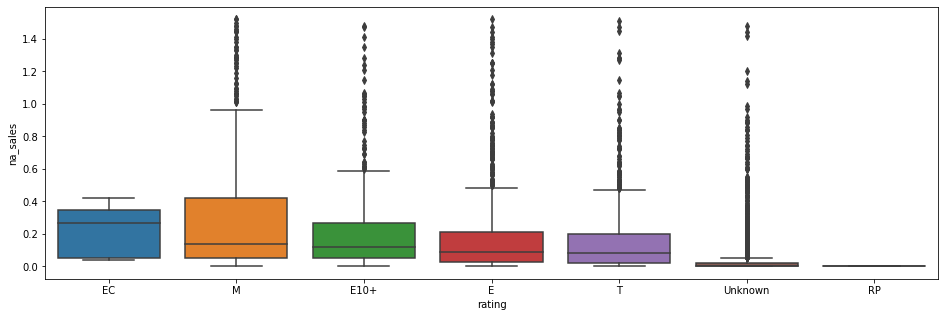

In [47]:
#Собираюсь посмотреть как рейтинг ESRB влияет на продажи в отдельном регионе
#рейтинг для США

esrb_na = games.query('year_of_release >= 2010 and na_sales < 1.53')
median_na = esrb_na.groupby(by=['rating'])['na_sales'].median().sort_values(ascending=False).index
fig, ax = plt.subplots(1,1,figsize=(16, 5))
sns.boxplot(x=esrb_na['rating'], y=esrb_na['na_sales'],ax=ax,order=median_na);

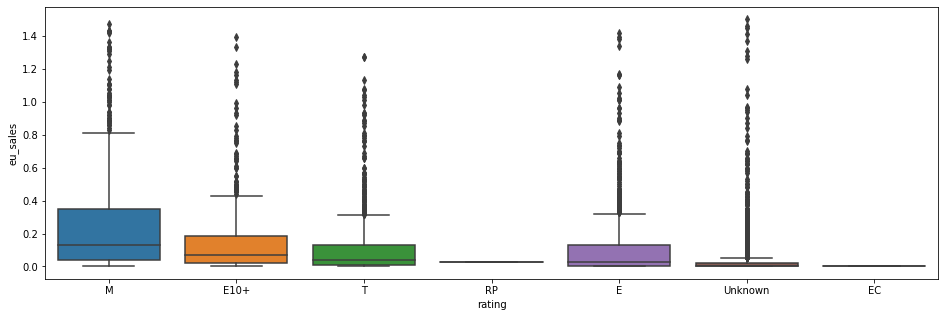

In [48]:
#рейтинг для Европы
esrb_eu = games.query('year_of_release >= 2010 and eu_sales < 1.53')
median_eu = esrb_eu.groupby(by=['rating'])['eu_sales'].median().sort_values(ascending=False).index
fig, ax = plt.subplots(1,1,figsize=(16, 5))
sns.boxplot(x=esrb_eu['rating'], y=esrb_eu['eu_sales'],ax=ax,order=median_eu);

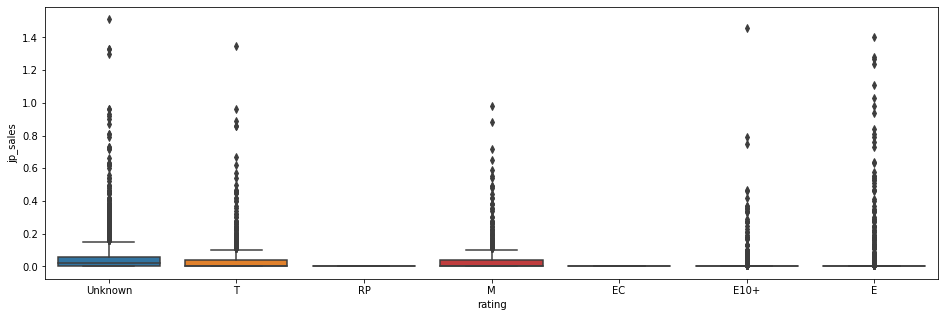

In [49]:
#Рейтинг для Японии
esrb_jp = games.query('year_of_release >= 2010 and jp_sales < 1.53')
median_jp = esrb_jp.groupby(by=['rating'])['jp_sales'].median().sort_values(ascending=False).index
fig, ax = plt.subplots(1,1,figsize=(16, 5))
sns.boxplot(x=esrb_jp['rating'], y=esrb_jp['jp_sales'],ax=ax,order=median_jp);

***Поставив срез актуального временного промежутка я выяснил что не все рейтинги актуальны в данный момент***

In [50]:
#хочу посмотреть сумарные и средние продажи игр в зависимости от оценко ESRB
na_rating_sales = games.query('year_of_release >= 2010 and platform in @top_5_platforms').pivot_table(
    index='rating',values='na_sales',aggfunc=['sum','mean'])
eu_rating_sales = games.query('year_of_release >= 2010 and platform in @top_5_platforms').pivot_table(
    index='rating',values='eu_sales',aggfunc=['sum','mean'])
jp_rating_sales = games.query('year_of_release >= 2010 and platform in @top_5_platforms').pivot_table(
    index='rating',values='jp_sales',aggfunc=['sum','mean'])

In [51]:
na_rating_sales

,sum,mean
,na_sales,na_sales
rating,,
E,49.29,0.225068
E10+,33.78,0.189775
EC,0.09,0.045000
M,111.90,0.331065
RP,0.00,0.000000
T,46.66,0.148127
Unknown,49.78,0.077660


In [52]:
eu_rating_sales

,sum,mean
,eu_sales,eu_sales
rating,,
E,58.84,0.268676
E10+,27.32,0.153483
EC,0.00,0.000000
M,115.59,0.341982
RP,0.03,0.030000
T,46.16,0.146540
Unknown,51.76,0.080749


In [53]:
jp_rating_sales

,sum,mean
,jp_sales,jp_sales
rating,,
E,7.96,0.036347
E10+,3.79,0.021292
EC,0.00,0.000000
M,7.66,0.022663
RP,0.00,0.000000
T,9.51,0.030190
Unknown,22.23,0.034680


***Игры игнорирующие оценки ESRB с рейтингом 'Unknown' хорошо продаются во всех регионах***

**Портреты пользователей из разных регионов:**
- В США пользователи предпочитают PS4 и XOne ,в жанрах отдают предпочтение Shooter и Platform с рейтингами ESRB - M,Unknown и E.
- В Европе пользователи предпочитают PS4 и PC,в жанрах отдают предпочтение Shooter и Sports с рейтингами ESRB - M,Unknown и E
- В Японии пользователи предпочитают PSV и PS4,в жанрах отдают предпочтение Platform и Role-Playing с рейтингами ESRB - Unknown,T и E.

### Проверка гипотез

***Собираюсь проверить гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые:
Моя нулевая гипотеза состоит в том что средние рйтинги равны,альтернативная гипотеза о том что они разные***

In [54]:
Xbox_One = games.query(
    'year_of_release >= 2010 and platform == "XOne" and user_score != "Unknown"')
PC = games.query(
    'year_of_release >= 2010 and platform == "PC" and user_score != "Unknown"')

alpha = 0.05  # критический уровень статистической значимости
results = st.ttest_ind(Xbox_One['user_score'], PC['user_score'])
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.23633954009311167
Не получилось отвергнуть нулевую гипотезу


***Мне не удалось отвергнуть гипотезу о том что средние рейтинги одинаковые***

***Собираюсь проверить гипотезу о том ,что средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.
 Моя нулевая гипотеза состоит в том что средние рйтинги равны,альтернативная гипотеза о том что они разные***

In [55]:
Action = games.query(
    'year_of_release >= 2010 and platform in @top_5_platforms and user_score != "Unknown"')
Sports = games.query(
    'year_of_release >= 2010 and platform in @top_5_platforms and user_score != "Unknown"')

alpha = 0.05  # критический уровень статистической значимости
results = st.ttest_ind(Action['user_score'], Sports['user_score'])
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.0
Не получилось отвергнуть нулевую гипотезу


***Мне не удалось отвергнуть гипотезу о том что средние рейтинги жанров Action и Sports одинаковые***

### Общий вывод

***Отвечая на главный вопрос о том на какие платформы и игры сделать ставку в следующем году я бы предложил консоли PS4 и XONE,так как эти консоли будут главными следующие пару лет.Основной акцент я предлагаю сделать на игры жанра Shooter,Sports и Platform с рейтиннгами Е и M.Но также во время исследования стало очевидно что при отсутствии оценки ESRB игры тоже хорошо продаются.От себя добавлю что удивлен такими плохими показателями ПК,но видимо это связано с пиратством и с бесплатным распостранением многопользовательских игр со встроенными покупками внутри.*** 